# Test notebook with CLIP scoring

In [ ]:
# !pip install flax transformers
# !git clone https://github.com/patil-suraj/vqgan-jax.git

In [2]:
import random

import jax
import flax.linen as nn
from flax.training.common_utils import shard
from flax.jax_utils import replicate, unreplicate

from transformers.models.bart.modeling_flax_bart import *
from transformers import BartTokenizer, FlaxBartForConditionalGeneration

import io

import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

jax.devices()

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host TPU


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

`dalle_mini` is a local package that contains the VQGAN-JAX model by Suraj, and other utilities. You can also `cd` to the directory that contains your checkout of [`vqgan-jax`](https://github.com/patil-suraj/vqgan-jax.git)

In [5]:
from dalle_mini.vqgan_jax.modeling_flax_vqgan import VQModel
#%cd /content/vqgan-jax

In [45]:
# TODO: set those args in a config file
OUTPUT_VOCAB_SIZE = 16384 + 1  # encoded image token space + 1 for bos
OUTPUT_LENGTH = 256 + 1  # number of encoded tokens + 1 for bos
BOS_TOKEN_ID = 16384
BASE_MODEL = 'facebook/bart-large-cnn'

In [46]:
class CustomFlaxBartModule(FlaxBartModule):
    def setup(self):
        # we keep shared to easily load pre-trained weights
        self.shared = nn.Embed(
            self.config.vocab_size,
            self.config.d_model,
            embedding_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
            dtype=self.dtype,
        )
        # a separate embedding is used for the decoder
        self.decoder_embed = nn.Embed(
            OUTPUT_VOCAB_SIZE,
            self.config.d_model,
            embedding_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
            dtype=self.dtype,
        )
        self.encoder = FlaxBartEncoder(self.config, dtype=self.dtype, embed_tokens=self.shared)

        # the decoder has a different config
        decoder_config = BartConfig(self.config.to_dict())
        decoder_config.max_position_embeddings = OUTPUT_LENGTH
        decoder_config.vocab_size = OUTPUT_VOCAB_SIZE
        self.decoder = FlaxBartDecoder(decoder_config, dtype=self.dtype, embed_tokens=self.decoder_embed)

class CustomFlaxBartForConditionalGenerationModule(FlaxBartForConditionalGenerationModule):
    def setup(self):
        self.model = CustomFlaxBartModule(config=self.config, dtype=self.dtype)
        self.lm_head = nn.Dense(
            OUTPUT_VOCAB_SIZE,
            use_bias=False,
            dtype=self.dtype,
            kernel_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
        )
        self.final_logits_bias = self.param("final_logits_bias", self.bias_init, (1, OUTPUT_VOCAB_SIZE))

class CustomFlaxBartForConditionalGeneration(FlaxBartForConditionalGeneration):
    module_class = CustomFlaxBartForConditionalGenerationModule

In [47]:
import wandb
run = wandb.init()
artifact = run.use_artifact('wandb/hf-flax-dalle-mini/model-3h3x3565:latest', type='bart_model')
artifact_dir = artifact.download()

2021-07-15 18:17:16.097767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


wandb: Downloading large artifact model-3h3x3565:latest, 1674.97MB. 2 files... Done. 0:0:0


In [48]:
# create our model
tokenizer = BartTokenizer.from_pretrained(BASE_MODEL)
model = CustomFlaxBartForConditionalGeneration.from_pretrained(artifact_dir)
model.config.force_bos_token_to_be_generated = False
model.config.forced_bos_token_id = None
model.config.forced_eos_token_id = None

# we verify that the shape has not been modified
model.params['final_logits_bias'].shape

tcmalloc: large alloc 1756332032 bytes == 0x55f32280a000 @  0x7f427b2ba680 0x7f427b2db824 0x55f0f1614730 0x55f0f172badb 0x55f0f17356a9 0x55f0f17567fe 0x55f0f1723684 0x55f0f16ea254 0x55f0f173c066 0x55f0f17474c6 0x55f0f16ea149 0x55f0f173b9c9 0x55f0f1785e8f 0x55f0f171361d 0x55f0f16e9e14 0x55f0f1726d84 0x55f0f16e9fab 0x55f0f1726d84 0x55f0f16e9fab 0x55f0f1726d84 0x55f0f172352a 0x55f0f16ea254 0x55f0f173c768 0x55f0f16e9e14 0x55f0f173c768 0x55f0f16ea254 0x55f0f173c066 0x55f0f173c85f 0x55f0f1747549 0x55f0f1710ede 0x55f0f176f120


(1, 16385)

In [49]:
vqgan = VQModel.from_pretrained("flax-community/vqgan_f16_16384")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [50]:
def custom_to_pil(x):
    x = np.clip(x, 0., 1.)
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def generate(input, rng, params):
  return model.generate(
      **input,
      max_length=257,
      num_beams=1,
      do_sample=True,
      prng_key=rng,
      eos_token_id=50000,
      pad_token_id=50000,
      params=params
  )

def get_images(indices, params):
    return vqgan.decode_code(indices, params=params)


def plot_images(images):
    fig = plt.figure(figsize=(40, 20))
    columns = 4
    rows = 2
    plt.subplots_adjust(hspace=0, wspace=0)

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()
    
def stack_reconstructions(images):
    w, h = images[0].size[0], images[0].size[1]
    img = Image.new("RGB", (len(images)*w, h))
    for i, img_ in enumerate(images):
        img.paste(img_, (i*w,0))
    return img

In [51]:
p_generate = jax.pmap(generate, "batch")
p_get_images = jax.pmap(get_images, "batch")

In [52]:
bart_params = replicate(model.params)
vqgan_params = replicate(vqgan.params)

In [63]:
prompts = [
    "man in blue jacket walking on pathway in between trees during daytime",
    'white snow covered mountain under blue sky during daytime',
    'white snow covered mountain under blue sky during night',
    "orange tabby cat on persons hand",
    "aerial view of beach during daytime",
    "chess pieces on chess board",
    "laptop on brown wooden table",
    "white bus on road near high rise buildings",
]


prompt = [prompts[1]] * jax.device_count()
inputs = tokenizer(prompt, return_tensors='jax', padding="max_length", truncation=True, max_length=128).data
inputs = shard(inputs)

In [ ]:
%%time
for i in range(8):
    key = random.randint(0, 1e7)
    rng = jax.random.PRNGKey(key)
    rngs = jax.random.split(rng, jax.local_device_count())
    indices = p_generate(inputs, rngs, bart_params).sequences
    indices = indices[:, :, 1:]

    images = p_get_images(indices, vqgan_params)
    images = np.squeeze(np.asarray(images), 1)
    imges = [custom_to_pil(image) for image in images]

    plt.figure(figsize=(40, 20))
    plt.imshow(stack_reconstructions(imges))

## CLIP Scoring

In [22]:
from transformers import CLIPProcessor, FlaxCLIPModel

In [24]:
clip = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [35]:
def hallucinate(prompt, num_images=64):
    prompt = [prompt] * jax.device_count()
    inputs = tokenizer(prompt, return_tensors='jax', padding="max_length", truncation=True, max_length=128).data
    inputs = shard(inputs)

    all_images = []
    for i in range(num_images // jax.device_count()):
        key = random.randint(0, 1e7)
        rng = jax.random.PRNGKey(key)
        rngs = jax.random.split(rng, jax.local_device_count())
        indices = p_generate(inputs, rngs, bart_params).sequences
        indices = indices[:, :, 1:]

        images = p_get_images(indices, vqgan_params)
        images = np.squeeze(np.asarray(images), 1)
        for image in images:
            all_images.append(custom_to_pil(image))
    return all_images

In [212]:
def clip_top_k(prompt, images, k=8):
    inputs = processor(text=prompt, images=images, return_tensors="np", padding=True)
    outputs = clip(**inputs)
    logits = outputs.logits_per_text
    scores = np.array(logits[0]).argsort()[-k:][::-1]
    return [images[score] for score in scores]

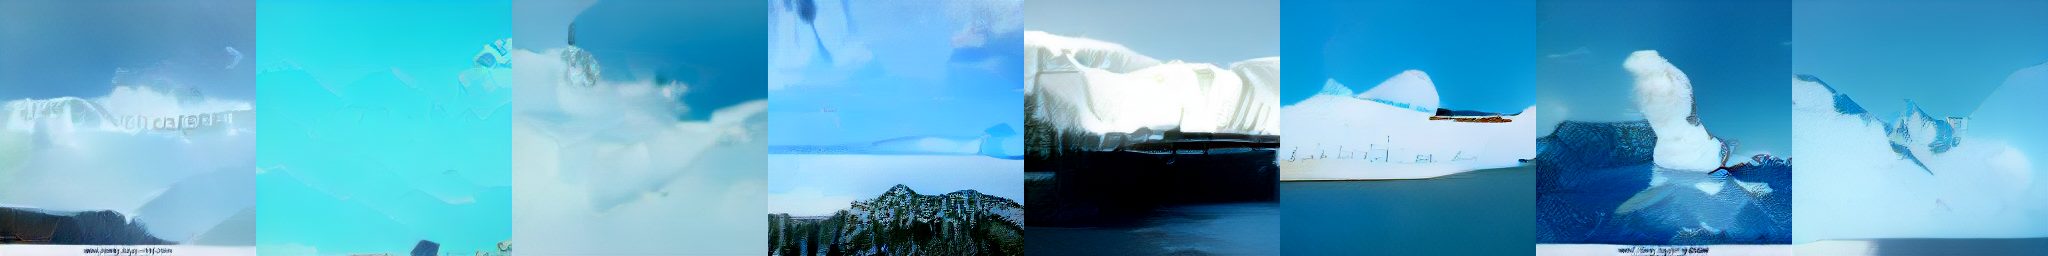

In [207]:
prompt = "white snow covered mountain under blue sky during daytime"
images = hallucinate(prompt)
selected = clip_top_k(prompt, images, k=8)
stack_reconstructions(selected)

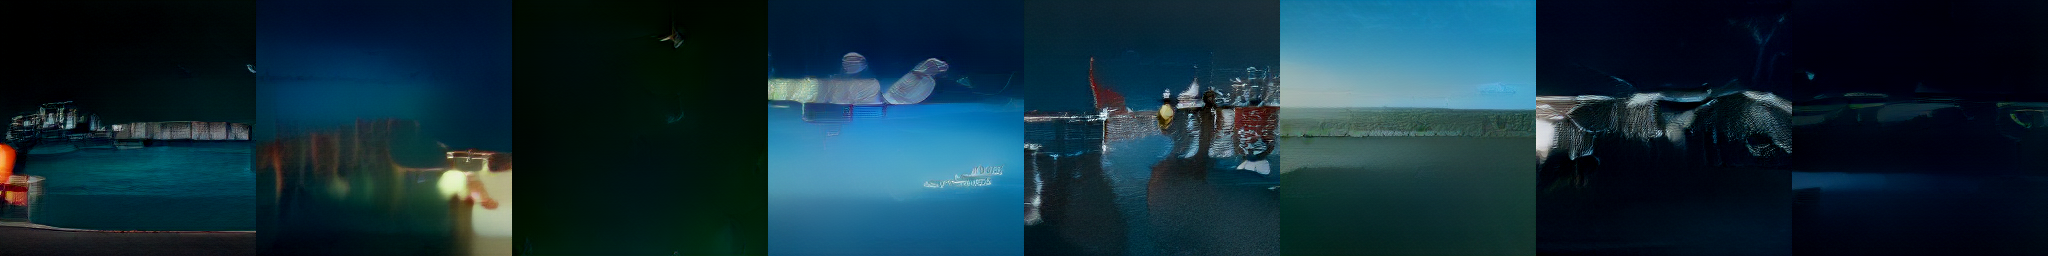

In [208]:
prompt = "aerial view of beach at night"
images = hallucinate(prompt)
selected = clip_top_k(prompt, images, k=8)
stack_reconstructions(selected)

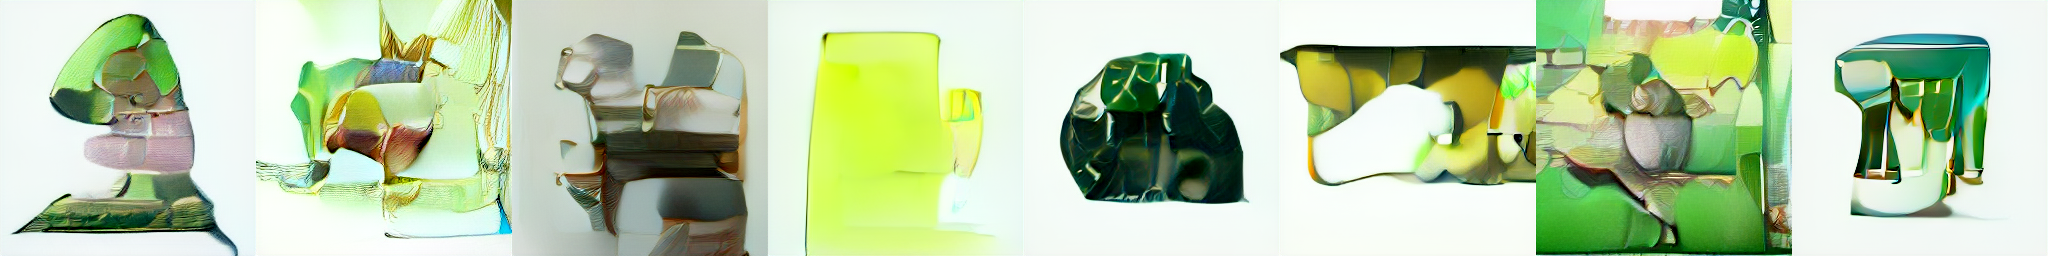

In [209]:
prompt = "an armchair in the shape of an avocado"
images = hallucinate(prompt)
selected = clip_top_k(prompt, images, k=8)
stack_reconstructions(selected)

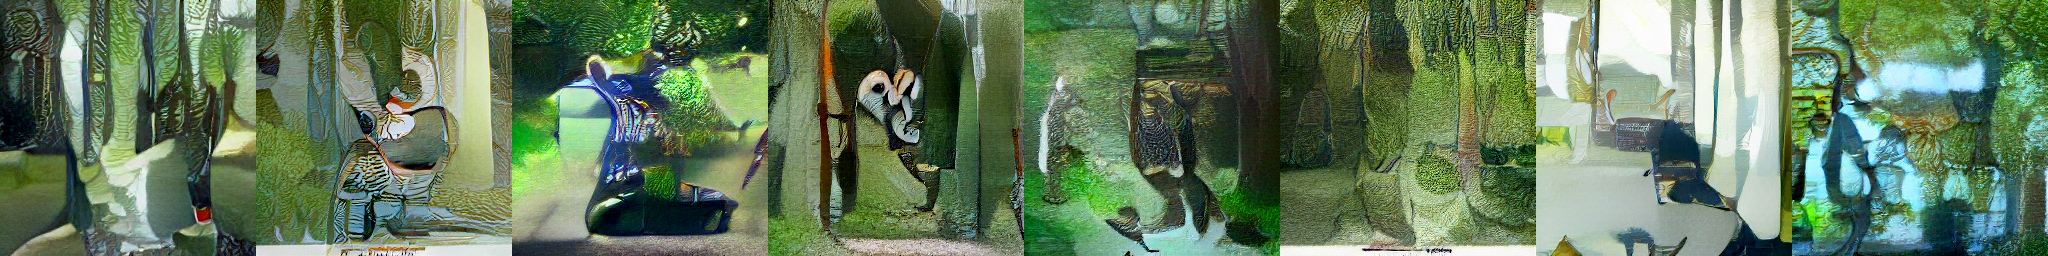

In [213]:
prompt = "young woman riding her bike into a forest"
images = hallucinate(prompt)
selected = clip_top_k(prompt, images, k=8)
stack_reconstructions(selected)

`Forest` seems to dominate. Interesting cubist interpretation in the fourth image.